# Задание

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

In [4]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'C:\Work\Python\my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
data.drop(['Time','year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek','hour','is_holiday','is_next_holiday','is_prev_holiday'], axis = 1, inplace = True)
data.head()

,PJME_MW
Date,
2002-01-01,30393.0
2002-01-01,29265.0
2002-01-01,28357.0
2002-01-01,27899.0
2002-01-01,28057.0


In [7]:
data_m = data.resample('M').mean()
data_m.head()

,PJME_MW
Date,
2002-01-31,31075.399731
2002-02-28,30239.166667
2002-03-31,28875.256720
2002-04-30,28534.731572
2002-05-31,28073.653226


### 2. Подберите параметры модели SARIMAX для этого ряда

In [8]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

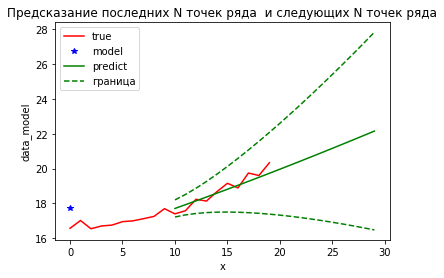

In [9]:
# ARIMA пример
from statsmodels.tsa.arima_model import ARIMA
from random import random
# модельный ряд
np.random.seed(21)
data_model = [x*0.3 +10*np.sin(x/20) + 0.7*np.random.random(1) for x in range(1, 100)]
N=10    # число точек для теста
# строим модель
model = ARIMA(data_model[:-N], order=(1, 1,2))
model_fit = model.fit(disp=False)
# делаем оценку старых значений
y_p = model_fit.predict(len(data_model[:-N]), len(data_model[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_model[-10-N:],'r',label ='true')
plt.plot(y_p,'*b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

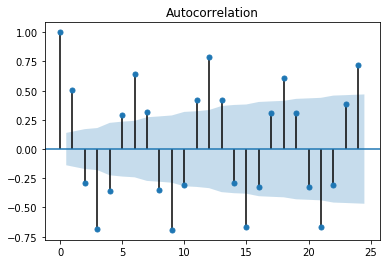

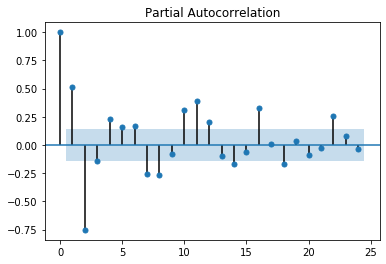

In [18]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
N = 12*2
### MA(q)
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=N)
plt.show()

### AR(p)
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=N)
plt.show()

In [29]:
import warnings
# Определим p, d и q  ##### PACF=AR(p), I(d) и ACF=MA(q)
q = 6
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 6 месяцев
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,6] 

In [30]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 2, 6]    : ps,ds,qs, S= [0, 0, 1, 6]


In [31]:
data_m.shape

(200, 1)

In [32]:
%%time
#для построения модели используем все данные, кроме 10-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-10],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 6]x[0, 0, 1, 6] - AIC:3241.1894574051603
Wall time: 735 ms


In [33]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  190
Model:             SARIMAX(1, 2, 6)x(0, 0, 1, 6)   Log Likelihood               -1611.595
Date:                           Sat, 09 May 2020   AIC                           3241.189
Time:                                   12:52:52   BIC                           3269.673
Sample:                                        0   HQIC                          3252.743
                                           - 190                                         
Covariance Type:                             opg                                         
========================================================================================= ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

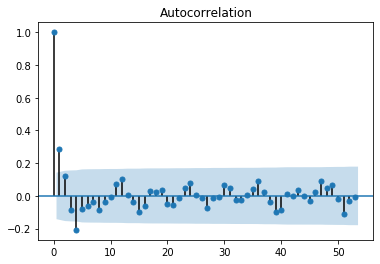

In [34]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

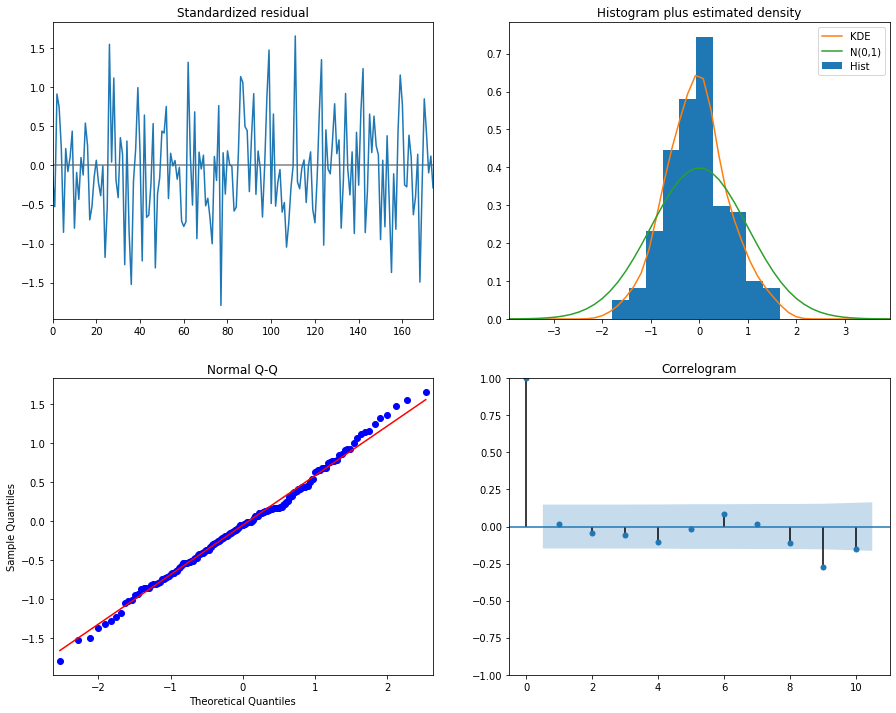

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [36]:
%%time
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0,1] 
d = [0,1]
q = range(0, 6)
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 0, 0, 6)
SARIMAX: (0, 0, 2) x (0, 0, 0, 6)
SARIMAX: (0, 0, 2) x (0, 0, 1, 6)
Wall time: 0 ns


In [42]:
%%time
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-10],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6) - AIC: 4463.051035665778
ARIMA(0, 0, 0)x(0, 0, 1, 6) - AIC: 4201.9169599367615
ARIMA(0, 0, 0)x(0, 0, 2, 6) - AIC: 4032.8632314963934
ARIMA(0, 0, 0)x(0, 0, 3, 6) - AIC: 3886.4251984132525
ARIMA(0, 0, 0)x(0, 0, 4, 6) - AIC: 3743.838804650911
ARIMA(0, 0, 0)x(0, 0, 5, 6) - AIC: 4116.513556741816
ARIMA(0, 0, 0)x(0, 1, 0, 6) - AIC: 3434.0624743755684
ARIMA(0, 0, 0)x(0, 1, 1, 6) - AIC: 3243.4896376616853
ARIMA(0, 0, 0)x(0, 1, 2, 6) - AIC: 3083.5912729163433
ARIMA(0, 0, 0)x(0, 1, 3, 6) - AIC: 2973.647273973536
ARIMA(0, 0, 0)x(0, 1, 4, 6) - AIC: 2820.2650808324233
ARIMA(0, 0, 0)x(0, 1, 5, 6) - AIC: 2780.321607199203
ARIMA(0, 0, 0)x(1, 0, 0, 6) - AIC: 3459.502526756797
ARIMA(0, 0, 0)x(1, 0, 1, 6) - AIC: 3428.5041216521167
ARIMA(0, 0, 0)x(1, 0, 2, 6) - AIC: 3211.154137623528
ARIMA(0, 0, 0)x(1, 0, 3, 6) - AIC: 3079.64276238997
ARIMA(0, 0, 0)x(1, 0, 4, 6) - AIC: 2973.498586038356
ARIMA(0, 0, 0)x(1, 0, 5, 6) - AIC: 2876.9206998693276
ARIMA(0, 0, 0)x(1, 1, 0, 6) - AIC: 318

Наилучший результат: ARIMA(0, 1, 2)x(1, 1, 5, 6) - AIC	2646.526356

In [44]:
%%time
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-10],order=[0,1,2],
                                seasonal_order=[1,1,5,6] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC: {results_opt.aic}')

AIC: 2646.526356044692
Wall time: 4.04 s


results: SARIMA(1, 2, 6)x(0, 0, 1, 6) - AIC: 3241.1894574051603

results_opt: SARIMA(0, 1, 2)x(1, 1, 5, 6) - AIC: 2646.526356

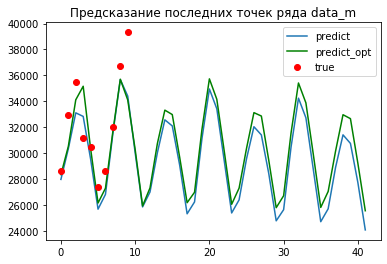

In [124]:
pred_dynamic = results.forecast(42)    
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-10:],'or',label='true')
plt.title('Предсказание последних точек ряда data_m')
plt.legend()

plt.show()

### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной

По сравнению с недельной моделью меясчная модель более грубая. Модель в крайних двух точках не смогла предсказать, хотя тренд верный.
Модель выбранная руками и которая выбрана по сетке не сильно отличаются :), но по сетке подбирать лучше, т.к. результат будет наилучший.

![title](data_w.png)

### 4. Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )
    https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv тут можно скачать актуальные данные. Дополнительно прикрепила датасет к материалам


In [157]:
#COVID = 'COVID'
Path_Energy = 'C:\Work\Python\covid_19_data.csv'
data = pd.read_csv(Path_Energy, index_col=[1], parse_dates=[1])

data.head()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-01-22,1,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,2,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2020-01-22,3,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
2020-01-22,4,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2020-01-22,5,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [158]:
data['Country/Region'].unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [159]:
data_swd = data[data['Country/Region']=='Sweden']

In [160]:
data_swd.head()

,SNo,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
ObservationDate,,,,,,,
2020-01-31,493,NaN,Sweden,1/31/2020 23:59,1.0,0.0,0.0
2020-02-01,554,NaN,Sweden,2/1/2020 2:13,1.0,0.0,0.0
2020-02-02,621,NaN,Sweden,2020-02-01T02:13:26,1.0,0.0,0.0
2020-02-03,690,NaN,Sweden,2020-02-01T02:13:26,1.0,0.0,0.0
2020-02-04,760,NaN,Sweden,2020-02-01T02:13:26,1.0,0.0,0.0


In [161]:
data_swd.columns

Index(['SNo', 'Province/State', 'Country/Region', 'Last Update', 'Confirmed',
       'Deaths', 'Recovered'],
      dtype='object')

In [162]:
data_swd.drop(['SNo','Province/State','Country/Region','Last Update','Deaths','Recovered'], axis = 1, inplace = True)

In [163]:
data_swd.head()

,Confirmed
ObservationDate,
2020-01-31,1.0
2020-02-01,1.0
2020-02-02,1.0
2020-02-03,1.0
2020-02-04,1.0


In [164]:
data_swd_d = data_swd.resample('D').mean()

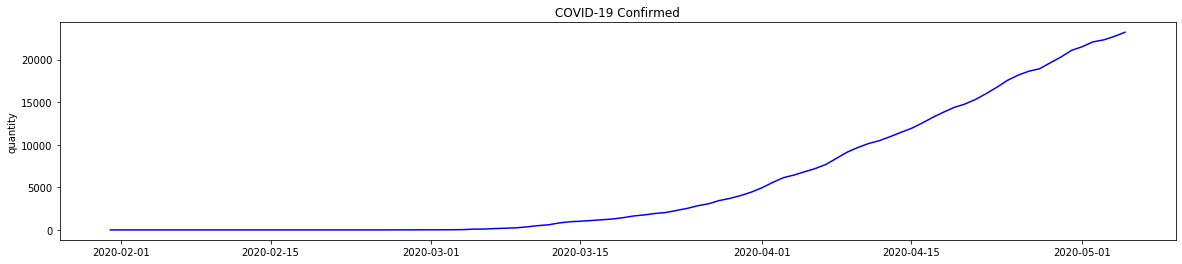

In [165]:
plt.figure(figsize =(20,4))
plt.plot( data_swd.index, data_swd['Confirmed'], 'b' )
plt.title('COVID-19 Confirmed' )
plt.ylabel ('quantity')
plt.show()

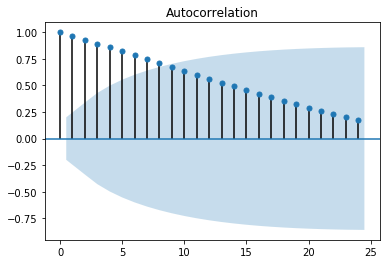

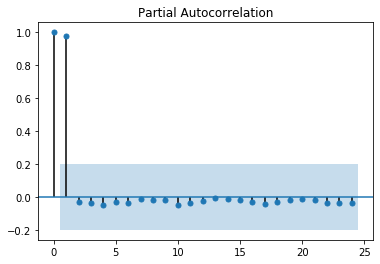

In [166]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
N = 12*2
### MA(q)
sm.graphics.tsa.plot_acf(data_swd_d['Confirmed'].values, lags=N)
plt.show()

### AR(p)
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_swd_d['Confirmed'].values, lags=N)
plt.show()

In [167]:
data_swd_d.shape

(96, 1)

AIC 991.5644145773518


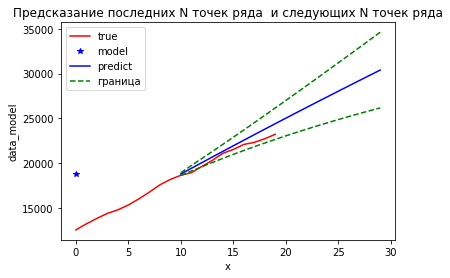

In [172]:
# ARIMA пример
from statsmodels.tsa.arima_model import ARIMA
from random import random
# модельный ряд
np.random.seed(21)
N=10    # число точек для теста
# строим модель
model = ARIMA(data_swd_d['Confirmed'].values[:-N], order=(1, 1, 2))
#model_fit = model.fit(disp=False)
model_fit = model.fit()
print(f'AIC {model_fit.aic}')



# делаем оценку старых значений
y_p = model_fit.predict(len(data_swd_d['Confirmed'].values[:-N]), len(data_swd_d['Confirmed'].values[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_swd_d['Confirmed'].values[-10-N:],'r',label ='true')
plt.plot(y_p,'*b',label ='model')

plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict', color='blue')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

### 5. Оцените результат моделирования
Модель ARIMA очень похожа на линейную регрессию, но это связано с исходными данными. У COVID в Швеции нет сезонности, цикличности и наблюдается тренд. Исходный график расположен в пределах границ прогноза.